Throughout the entire journey of this project, I tried so many things....


*   Hardware: Kaggle, Google Colab, Local server, Paper Gradient
*   AutoML: Pycaret, Auto-Sklearn, MLJAR, AutoGluon
*   Individual Models: CatBoost, XGBoost
*   Encoding Methods: M-estimate encoder, target encoder, CatBoost encoder, James-Stein encoder, leave one out encoder, mixed effects encoder...
*   Feature selection methods: variance thresholding, correlation, Catboost correlation
*   Feature engineering: arithmetic combinations (sum of 2 columns, product of 2 columns, divide 2 columns, subtraction of 2 columns, columns squared, columns cubed)
.....

However, I only want to present the best solution here, because the other things I tried were quite unsuccessful.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
! pip install feature-engine -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 176.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
# to get no error executing this kernel, it is neccessary to update catboost to version 0.14.2 +
!pip install catboost>=0.14.2 -q

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import SmartCorrelatedSelection

In [ ]:
training_df = pd.read_csv("/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/train.csv")
testing_df = pd.read_csv("/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/test.csv")
# training_df = pd.read_csv("/content/train.csv")
# testing_df = pd.read_csv("/content/test.csv")
original_training_df = training_df.copy()
original_testing_df = testing_df.copy()

training_df = training_df.drop(['ID'], axis = 1)
testing_df = testing_df.drop(['ID'], axis = 1)

# Drop columns with  > 80% missing

In [ ]:
# Set the threshold for dropping columns (e.g., 90%)
missing_threshold = max(np.sum(training_df['target'])/training_df.shape[0], 0.8)
print(f"Missing threshold: {missing_threshold}")

# Calculate the percentage of NaN values in each column
nan_percentage = training_df.isna().mean()

# Identify columns exceeding the threshold
columns_to_drop = nan_percentage[nan_percentage > missing_threshold].index
print(columns_to_drop)

# Drop the identified columns
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

Missing threshold: 0.8
Index([], dtype='object')


# Drop rows with  > 80% missing

In [ ]:
# Calculate the percentage of NaN values in each row
nan_percentage = training_df.isna().mean(axis=1)

# Identify rows exceeding the threshold
rows_to_drop = nan_percentage[nan_percentage > missing_threshold].index
print(rows_to_drop, len(rows_to_drop), training_df.shape[0],
      f"Percentage of rows to be dropped {len(rows_to_drop)/training_df.shape[0]}")

# Drop the identified rows
training_df = training_df.drop(index=rows_to_drop)
original_training_df = original_training_df.drop(index=rows_to_drop)

Int64Index([  2179,   2841,   3779,   8848,   8932,   9182,  10564,  11522,
             11625,  14659,  17073,  19931,  20150,  20286,  20508,  20991,
             21951,  22051,  22155,  22718,  24022,  24114,  24252,  27834,
             28524,  29684,  30928,  31081,  31519,  32810,  34788,  35956,
             36794,  36819,  37398,  37959,  39392,  41677,  44522,  46128,
             46651,  46680,  48674,  50248,  50413,  51020,  52107,  52436,
             54008,  58681,  59613,  59815,  61590,  61838,  62264,  65970,
             69261,  69795,  71405,  72116,  73703,  78396,  80335,  81149,
             81431,  82060,  84800,  85627,  86407,  86505,  86864,  88259,
             89848,  94609,  97083,  97300,  97422,  97796,  97985,  98664,
             99243,  99304, 103880, 104384, 104795, 105419, 106807, 109655,
            110530, 110683, 112868, 112918],
           dtype='int64') 92 114321 Percentage of rows to be dropped 0.0008047515329641973


# Drop duplicate features

Based on the comment here: https://www.kaggle.com/competitions/bnp-paribas-cardif-claims-management/discussion/19240
there are a few categorical variables that have been suggested to drop

In [ ]:
duplicate_features_to_drop = []

In [ ]:
duplicate_feature_transformer = DropDuplicateFeatures()
# fit the transformer
duplicate_feature_transformer.fit(training_df.drop('target', axis =1).to_numpy())
print(duplicate_feature_transformer.features_to_drop_)
print(duplicate_feature_transformer.duplicated_feature_sets_)
if len(duplicate_feature_transformer.features_to_drop_) != 0:
  duplicate_features_to_drop = duplicate_features_to_drop + list(duplicate_feature_transformer.features_to_drop_)

set()
[]


In [ ]:
training_df = training_df.drop(duplicate_features_to_drop, axis = 1)
testing_df = testing_df.drop(duplicate_features_to_drop, axis = 1)

# Categorical Feature Combinations

According to the [3rd winning solution](https://www.kaggle.com/competitions/bnp-paribas-cardif-claims-management/discussion/20258), creating 2 way and 3 way categorical variables helped.

In [ ]:

# List of category column names
category_columns = list(set(training_df.select_dtypes(include='object').columns))

# Create a new DataFrame to store the combinations
cat_combinations_training_df = pd.DataFrame()
cat_combinations_testing_df = pd.DataFrame()

# Generate all possible combinations of 2 categories
for combo in tqdm(itertools.combinations(category_columns, 2)):
    column_name = '_'.join(combo)
    cat_combinations_training_df[column_name] = training_df[list(combo)].astype(str).agg(''.join, axis=1)
    cat_combinations_testing_df[column_name] = testing_df[list(combo)].astype(str).agg(''.join, axis=1)

# Generate all possible combinations of 2 categories with v22, as recommended
temp_category_columns = category_columns.copy()
temp_category_columns.remove('v22')

for combo in tqdm(itertools.combinations(category_columns, 2)):
    combo = combo + ('v22',)
    column_name = '_'.join(combo)
    cat_combinations_training_df[column_name] = training_df[list(combo)].astype(str).agg(''.join, axis=1)
    cat_combinations_testing_df[column_name] = testing_df[list(combo)].astype(str).agg(''.join, axis=1)

<ipython-input-11-d764f03ff95f>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for combo in tqdm(itertools.combinations(category_columns, 2)):


0it [00:00, ?it/s]

<ipython-input-11-d764f03ff95f>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_combinations_training_df[column_name] = training_df[list(combo)].astype(str).agg(''.join, axis=1)
<ipython-input-11-d764f03ff95f>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_combinations_testing_df[column_name] = testing_df[list(combo)].astype(str).agg(''.join, axis=1)
<ipython-input-11-d764f03ff95f>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

0it [00:00, ?it/s]

<ipython-input-11-d764f03ff95f>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_combinations_training_df[column_name] = training_df[list(combo)].astype(str).agg(''.join, axis=1)
<ipython-input-11-d764f03ff95f>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_combinations_testing_df[column_name] = testing_df[list(combo)].astype(str).agg(''.join, axis=1)
<ipython-input-11-d764f03ff95f>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [ ]:
cat_combinations_training_df

,v24_v74,v24_v75,v24_v110,v24_v107,v24_v112,v24_v79,v24_v30,v24_v22,v24_v66,v24_v71,...,v47_v52_v22,v47_v125_v22,v47_v3_v22,v47_v31_v22,v52_v125_v22,v52_v3_v22,v52_v31_v22,v125_v3_v22,v125_v31_v22,v3_v31_v22
0,CB,CD,CB,CE,CO,CE,CC,CXDX,CC,CF,...,CGXDX,CAUXDX,CCXDX,CAXDX,GAUXDX,GCXDX,GAXDX,AUCXDX,AUAXDX,CAXDX
1,CB,CD,CA,CB,CU,CD,CC,CGUV,CA,CF,...,EGGUV,EAFGUV,ECGUV,EAGUV,GAFGUV,GCGUV,GAGUV,AFCGUV,AFAGUV,CAGUV
2,EB,EB,EB,EC,ES,EE,Ena_filler,EFQ,EA,EB,...,CFFQ,CAEFQ,CCFQ,CAFQ,FAEFQ,FCFQ,FAFQ,AECFQ,AEAFQ,CAFQ
3,DB,DD,DB,DB,DJ,DB,DC,DACUE,DA,DF,...,CHACUE,CCJACUE,CCACUE,CBACUE,HCJACUE,HCACUE,HBACUE,CJCACUE,CJBACUE,CBACUE
4,EB,ED,EA,EC,ET,EC,Ena_filler,EHIT,EC,EF,...,IHHIT,IZHIT,ICHIT,IAHIT,HZHIT,HCHIT,HAHIT,ZCHIT,ZAHIT,CAHIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,EB,EB,EA,EE,EU,EC,Ena_filler,EADQC,EA,EB,...,IEADQC,IALADQC,ICADQC,IAADQC,EALADQC,ECADQC,EAADQC,ALCADQC,ALAADQC,CAADQC
114317,DB,DD,DB,DC,DJ,DB,Dna_filler,DXRT,DA,DF,...,CIXRT,CEXRT,CCXRT,CBXRT,IEXRT,ICXRT,IBXRT,ECXRT,EBXRT,CBXRT
114318,AB,AB,AB,AC,AR,AB,AC,AAGTG,AA,AB,...,CDAGTG,CQAGTG,CCAGTG,CBAGTG,DQAGTG,DCAGTG,DBAGTG,QCAGTG,QBAGTG,CBAGTG
114319,DB,DD,DB,DE,DA,DE,DG,DSGB,DA,DF,...,CJSGB,CBWSGB,CCSGB,CASGB,JBWSGB,JCSGB,JASGB,BWCSGB,BWASGB,CASGB


In [ ]:
cat_combinations_testing_df

,v24_v74,v24_v75,v24_v110,v24_v107,v24_v112,v24_v79,v24_v30,v24_v22,v24_v66,v24_v71,...,v47_v52_v22,v47_v125_v22,v47_v3_v22,v47_v31_v22,v52_v125_v22,v52_v3_v22,v52_v31_v22,v125_v3_v22,v125_v31_v22,v3_v31_v22
0,EB,ED,EA,EB,EU,EQ,Ena_filler,EAFPB,EA,EF,...,JCAFPB,JAFAFPB,JCAFPB,JAAFPB,CAFAFPB,CCAFPB,CAAFPB,AFCAFPB,AFAAFPB,CAAFPB
1,DB,DD,DB,DD,DE,DE,DA,DFOG,DC,DF,...,CAFOG,CIFOG,CCFOG,CAFOG,AIFOG,ACFOG,AAFOG,ICFOG,IAFOG,CAFOG
2,BB,BD,BA,BD,BQ,BC,BC,BHXZ,BC,BF,...,IAHXZ,IAVHXZ,ICHXZ,IAHXZ,AAVHXZ,ACHXZ,AAHXZ,AVCHXZ,AVAHXZ,CAHXZ
3,EB,ED,EA,EB,EF,EC,EE,EAGMU,EB,EF,...,IAAGMU,IBAGMU,ICAGMU,IAAGMU,ABAGMU,ACAGMU,AAAGMU,BCAGMU,BAAGMU,CAAGMU
4,EB,ED,EA,EB,EA,EC,EC,EAWW,EB,EF,...,IHAWW,IAAWW,ICAWW,IAAWW,HAAWW,HCAWW,HAAWW,ACAWW,AAAWW,CAAWW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114388,DB,DB,DA,DB,DA,DC,Dna_filler,DADRO,DC,DB,...,IGADRO,IAGADRO,ICADRO,IAADRO,GAGADRO,GCADRO,GAADRO,AGCADRO,AGAADRO,CAADRO
114389,DB,DD,DA,DD,DP,DI,Dna_filler,DTFN,DA,DF,...,IHTFN,IHTFN,ICTFN,IATFN,HHTFN,HCTFN,HATFN,HCTFN,HATFN,CATFN
114390,CB,CB,CB,CA,CA,CE,CC,CYOD,CB,CB,...,CKYOD,CVYOD,CCYOD,CAYOD,KVYOD,KCYOD,KAYOD,VCYOD,VAYOD,CAYOD
114391,EB,ED,EB,EC,EF,EB,Ena_filler,EAGDF,EC,EF,...,CIAGDF,CAZAGDF,CCAGDF,CAAGDF,IAZAGDF,ICAGDF,IAAGDF,AZCAGDF,AZAAGDF,CAAGDF


In [ ]:
cat_combinations_training_df = cat_combinations_training_df.sort_index()
cat_combinations_testing_df = cat_combinations_testing_df.sort_index()

cat_combinations_training_df['ID'] = original_training_df['ID']
cat_combinations_testing_df['ID'] = original_testing_df['ID']

cat_combinations_training_df.to_csv('training_cat_combinations.csv', index = False)
cat_combinations_testing_df.to_csv('testing_cat_combinations.csv', index = False)

training_combinations_df = pd.concat([training_df, cat_combinations_training_df], axis = 1)
testing_combinations_df = pd.concat([testing_df, cat_combinations_testing_df], axis = 1)
training_combinations_df.to_csv('training_wcombinations.csv', index = False)
testing_combinations_df.to_csv('testing_wcombinations.csv', index = False)

In [ ]:
!mv "training_cat_combinations.csv" "/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/"
!mv "testing_cat_combinations.csv" "/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/"
!mv "training_wcombinations.csv" "/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/"
!mv "testing_wcombinations.csv" "/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/"

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from tqdm import tqdm

In [ ]:
training_df = pd.read_csv("/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/training_catboost_features.csv")
testing_df =pd.read_csv("/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/testing_catboost_features.csv")


y = training_df['target']
X = training_df.drop('target', axis =1 )
X_test = testing_df

X_test_ID = X_test['ID']
X_test = X_test.drop('ID', axis = 1)
X_ID = X['ID']
X = X.drop(['ID'], axis = 1)

categorical_features = X.select_dtypes(include=['object','int', 'string']).columns
for i in tqdm(categorical_features):
  X[i] = X[i].astype(str)
  X_test[i] = X_test[i].astype(str)

100%|██████████| 206/206 [01:13<00:00,  2.80it/s]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1,
    stratify = y,
    test_size = 0.15,
)

# Feature Selection

In [ ]:
params = {
    'cat_features': list(training_df.drop(['target','ID'], axis =1 ).select_dtypes(include=['object','int', 'string']).columns),
    'loss_function':'Logloss',
    'eval_metric':'Logloss',
    'task_type': 'GPU', ## We use GPU
    'verbose': 200,
    'random_seed': 8450,
    # 'max_ctr_complexity': 10,
    'iterations': 2000,
    # 'auto_class_weights': True,
         }
cbc_5 = CatBoostClassifier(**params)
cbc_5.select_features(
                X_train,
                y=y_train,
                eval_set=(X_valid, y_valid),
                num_features_to_select=150,
                algorithm='RecursiveByLossFunctionChange',
                features_for_select=training_df.drop(['target','ID'], axis =1 ).columns.to_list(),
                steps=2,
                verbose = 150,
                train_final_model=False,
                shap_calc_type = 'Exact',
                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.036223
Step #1 out of 2
0:	learn: 0.6755790	test: 0.6756151	best: 0.6756151 (0)	total: 241ms	remaining: 8m 1s
150:	learn: 0.4557798	test: 0.4533104	best: 0.4533104 (150)	total: 31.6s	remaining: 6m 26s
300:	learn: 0.4482495	test: 0.4469431	best: 0.4469431 (300)	total: 1m 4s	remaining: 6m 4s
450:	learn: 0.4438431	test: 0.4450177	best: 0.4450177 (450)	total: 1m 36s	remaining: 5m 30s
600:	learn: 0.4403726	test: 0.4438924	best: 0.4438924 (600)	total: 2m 7s	remaining: 4m 55s
750:	learn: 0.4370885	test: 0.4432509	best: 0.4432439 (749)	total: 2m 41s	remaining: 4m 27s
900:	learn: 0.4340293	test: 0.4427298	best: 0.4427169 (897)	total: 3m 11s	remaining: 3m 53s
1050:	learn: 0.4311893	test: 0.4422790	best: 0.4422790 (1050)	total: 3m 42s	remaining: 3m 21s
1200:	learn: 0.4283877	test: 0.4419451	best: 0.4419439 (1199)	total: 4m 14s	remaining: 2m 49s
1350:	learn: 0.4255601	test: 0.4417277	best: 0.4417212 (1348)	total: 4m 47s	remaining: 2m 18s
1500:	learn: 0.4226761	test: 0.441426

{'selected_features': [1,
  3,
  4,
  5,
  6,
  7,
  10,
  12,
  13,
  14,
  15,
  20,
  22,
  23,
  24,
  25,
  30,
  32,
  33,
  34,
  37,
  38,
  41,
  42,
  44,
  45,
  46,
  48,
  49,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  64,
  66,
  68,
  69,
  70,
  71,
  72,
  73,
  75,
  76,
  77,
  78,
  79,
  81,
  82,
  83,
  84,
  88,
  89,
  90,
  93,
  95,
  96,
  97,
  99,
  101,
  102,
  103,
  106,
  108,
  112,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  124,
  127,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  139,
  140,
  141,
  143,
  144,
  146,
  148,
  149,
  154,
  156,
  157,
  159,
  160,
  161,
  162,
  163,
  165,
  166,
  171,
  172,
  174,
  175,
  177,
  178,
  182,
  185,
  190,
  191,
  192,
  193,
  194,
  195,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  211,
  212,
  213,
  214,
  215,
  217,
  219,
  226,
  227,
  228,
  229,
  230,
  231,
  233,
  234,
  236,
  237,
  238,
  241,
  242,
  245,
  247,
  249]

In [ ]:
catboost_150_features = ['v10',
  'v14',
  'v15',
  'v20',
  'v21',
  'v22',
  'v25',
  'v29',
  'v30',
  'v32',
  'v34',
  'v40',
  'v42',
  'v47',
  'v49',
  'v50',
  'v62',
  'v66',
  'v67',
  'v72',
  'v78',
  'v79',
  'v92',
  'v96',
  'v105',
  'v113',
  'v114',
  'v118',
  'v119',
  'v123',
  'v127',
  'v129',
  'v24_v75',
  'v24_v110',
  'v24_v107',
  'v24_v112',
  'v24_v30',
  'v24_v66',
  'v24_v113',
  'v24_v52',
  'v24_v31',
  'v74_v79',
  'v74_v30',
  'v74_v22',
  'v74_v66',
  'v74_v113',
  'v74_v56',
  'v74_v31',
  'v75_v107',
  'v75_v112',
  'v75_v30',
  'v75_v66',
  'v75_v113',
  'v75_v56',
  'v75_v47',
  'v75_v125',
  'v110_v66',
  'v110_v71',
  'v110_v113',
  'v110_v125',
  'v107_v79',
  'v107_v30',
  'v107_v66',
  'v107_v113',
  'v107_v47',
  'v107_v52',
  'v107_v3',
  'v112_v66',
  'v112_v56',
  'v79_v71',
  'v79_v56',
  'v79_v47',
  'v79_v52',
  'v79_v31',
  'v30_v66',
  'v30_v113',
  'v30_v56',
  'v30_v52',
  'v30_v3',
  'v22_v113',
  'v22_v125',
  'v66_v113',
  'v66_v56',
  'v66_v52',
  'v66_v125',
  'v66_v3',
  'v66_v31',
  'v71_v113',
  'v71_v31',
  'v113_v56',
  'v113_v52',
  'v113_v3',
  'v113_v31',
  'v56_v52',
  'v47_v3',
  'v52_v125',
  'v24_v107_v22',
  'v24_v30_v22',
  'v24_v71_v22',
  'v24_v56_v22',
  'v24_v52_v22',
  'v24_v3_v22',
  'v24_v31_v22',
  'v74_v110_v22',
  'v74_v79_v22',
  'v74_v22_v22',
  'v74_v3_v22',
  'v75_v107_v22',
  'v75_v30_v22',
  'v75_v66_v22',
  'v75_v113_v22',
  'v75_v56_v22',
  'v110_v30_v22',
  'v110_v113_v22',
  'v107_v79_v22',
  'v107_v30_v22',
  'v107_v71_v22',
  'v107_v113_v22',
  'v107_v56_v22',
  'v107_v52_v22',
  'v79_v30_v22',
  'v79_v22_v22',
  'v79_v66_v22',
  'v79_v71_v22',
  'v79_v113_v22',
  'v79_v56_v22',
  'v79_v47_v22',
  'v79_v31_v22',
  'v30_v66_v22',
  'v30_v71_v22',
  'v30_v113_v22',
  'v30_v56_v22',
  'v30_v52_v22',
  'v22_v71_v22',
  'v66_v71_v22',
  'v66_v113_v22',
  'v66_v56_v22',
  'v66_v47_v22',
  'v71_v113_v22',
  'v71_v56_v22',
  'v71_v52_v22',
  'v71_v125_v22',
  'v71_v31_v22',
  'v113_v56_v22',
  'v113_v52_v22',
  'v56_v47_v22',
  'v56_v52_v22',
  'v56_v31_v22',
  'v52_v31_v22',
  'v3_v31_v22']

In [ ]:
y = training_df['target']
X = training_df[catboost_150_features]
X_test = testing_df[catboost_150_features]

X_test_ID = testing_df['ID']
X_test = X_test.drop('ID', axis = 1, errors='ignore')
X_ID = training_df['ID']
X = X.drop(['ID'], axis = 1, errors='ignore')

categorical_features = X.select_dtypes(include=['object','int']).columns
for i in tqdm(categorical_features):
  X[i] = X[i].astype(str)
  X_test[i] = X_test[i].astype(str)

100%|██████████| 127/127 [00:24<00:00,  5.16it/s]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1,
    stratify = y,
    test_size = 0.05,
)

# Train CatBoost

In [ ]:
params = {
    'cat_features': list(training_df[catboost_150_features].select_dtypes(include=['object','int', 'string']).columns),
    'loss_function':'Logloss',
    'eval_metric':'Logloss',
    'task_type': 'GPU', ## We use GPU
    'verbose': 200,
    'random_seed': 8450,
    'max_ctr_complexity': 13,
    'iterations': 15000,
    # 'auto_class_weights': True,
         }
cbc_7 = CatBoostClassifier(**params)

cbc_7.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True,
         );
print(cbc_7.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.018429
0:	learn: 0.6844460	test: 0.6844262	best: 0.6844262 (0)	total: 219ms	remaining: 36m 29s
200:	learn: 0.4603734	test: 0.4591902	best: 0.4591902 (200)	total: 34.5s	remaining: 28m 3s
400:	learn: 0.4511046	test: 0.4488520	best: 0.4488455 (398)	total: 1m 10s	remaining: 28m 7s
600:	learn: 0.4470158	test: 0.4454941	best: 0.4454941 (600)	total: 1m 45s	remaining: 27m 27s
800:	learn: 0.4440317	test: 0.4436728	best: 0.4436728 (800)	total: 2m 20s	remaining: 26m 57s
1000:	learn: 0.4417094	test: 0.4427977	best: 0.4427958 (998)	total: 2m 56s	remaining: 26m 30s
1200:	learn: 0.4395405	test: 0.4419926	best: 0.4419926 (1200)	total: 3m 33s	remaining: 26m 4s
1400:	learn: 0.4376058	test: 0.4413912	best: 0.4413861 (1399)	total: 4m 10s	remaining: 25m 37s
1600:	learn: 0.4356819	test: 0.4410130	best: 0.4409954 (1595)	total: 4m 47s	remaining: 25m 9s
1800:	learn: 0.4339228	test: 0.4407473	best: 0.4407248 (1785)	total: 5m 23s	remaining: 24m 31s
2000:	learn: 0.4321609	test: 0.4405683	be

In [ ]:
submission_df = pd.DataFrame()
submission_df['PredictedProb'] = cbc_7.predict_proba(X_test)[:,1]
submission_df['ID'] = testing_df['ID'].copy()
submission_df.to_csv("catboost-submission.csv", index= False)

In [ ]:
!mv "/content/catboost-submission.csv" "/gdrive/Shareddrives/FTCM/CIS335 ML&AI/Comprehensive ML Project 1 - Ian Liu/dataset/catboost-submission7.csv"

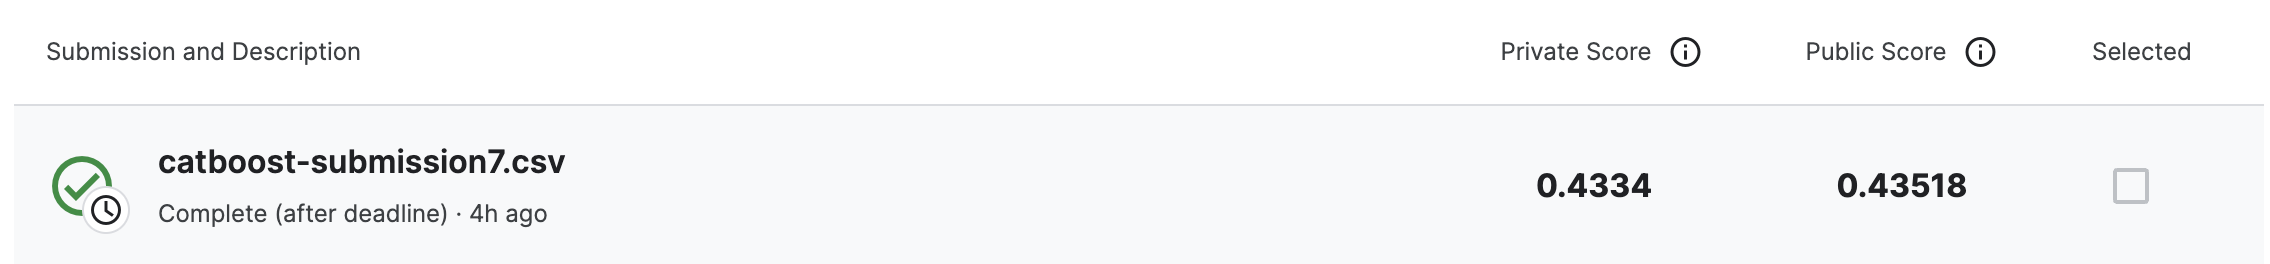

# My other results:


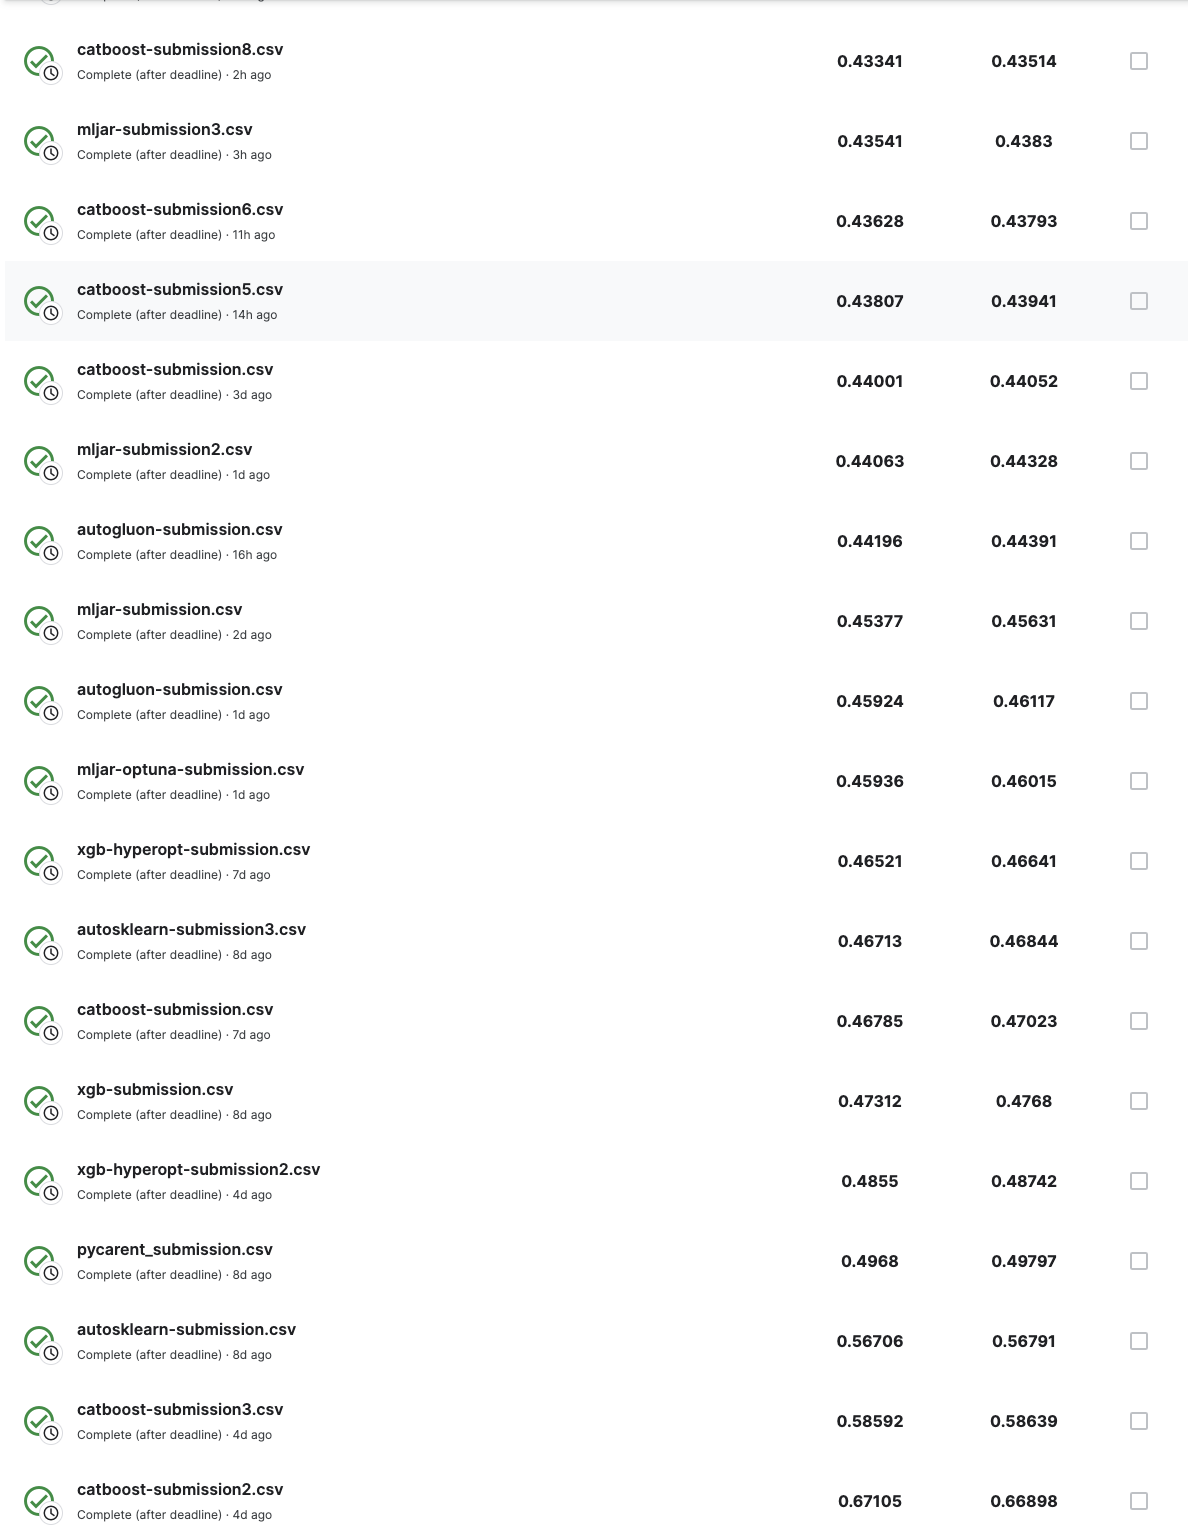

# LINKS TO OTHER NOTEBOOKS:

Pycaret:
https://colab.research.google.com/drive/11Ew8MoouYIFRoU5HWvu5D4zcj50gL1qV?usp=drive_link

Catboost and attempt at Xfeat: https://drive.google.com/file/d/1wLb3SsEbigEOpSPVCwgMX-4z1skFEsrM/view?usp=drive_link

MLJAR:
https://colab.research.google.com/drive/1287efhHW-1HTbFIWarAXnZLcwO-oSF7D?usp=drive_link


https://drive.google.com/file/d/1_kyA56pDIuvuDHKRfkcu85IHgKwNo29V/view?usp=drive_link

AutoGluon:

https://drive.google.com/file/d/1uKPu3AfFaC6PrNtGxdl5SmQPn0Ezp8ra/view?usp=drive_link

https://colab.research.google.com/drive/1MnYem2RhBDa_9duMQzKiflZfADWT5xSD?usp=drive_link

Auto-Sklearn:

https://colab.research.google.com/drive/1mz1aK3S1_T9IcUJM9V7_jZPA2X9gJ__k?usp=drive_link

Feature Engineering experimentation:

https://colab.research.google.com/drive/1AQM_6CuwUntmIYDLHo-q5UGAfFXZW6st?usp=drive_link

# CONCLUSION
- I think this project was more challenging than I thought, but it's more because I overcomplicated things. Instead of focusing on one approach, I tried too many things at one time.

Difficulties: I ran out of GPU on colab, had a crashing kernel locally, paid for Paperspace Gradient servers but they ran out of free servers, was not able to run Xfeat on Colab or Kaggle or Paperspace, and more...

Many of these would not have happened if I just focused on doing one thing well. I think I should've spent more time on Catboost and feature engineering. I think I wasted time on imputation (because Catboost can handle missing data), encoding (because Catboost can handle categorical features). I think I didn't spend enough time on feature selection. I also spent slightly too much time trying out AutoML because I was lazy and expected magic to happen.